In [338]:
import numpy as np
import scipy
import scipy.stats
import torch as t

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from torch.nn import Sequential, Linear, ReLU, LeakyReLU, Dropout, Sigmoid

In [339]:
%matplotlib inline

In [340]:
if t.cuda.is_available():
    if t.cuda.device_count()>1:
        device = t.device('cuda:1')
    else:
        device = t.device('cuda')   
else:
    device = t.device('cpu')

In [341]:
device=t.device('cpu') #Overrride the above device choice

Generate the sample 2D distribution: uniform from unit circle.  

In [342]:
angle = np.random.uniform(-np.pi,np.pi,(1000,1)).astype('float32')
data = np.concatenate((np.cos(angle), np.sin(angle)),axis=1)

In [343]:
np.cos(angle)

array([[ 0.9495526 ],
       [-0.48747662],
       [ 0.4047644 ],
       [ 0.60859936],
       [ 0.3019716 ],
       [ 0.6403418 ],
       [-0.5411353 ],
       [ 0.99100924],
       [-0.98215514],
       [-0.71583205],
       [-0.71676123],
       [-0.32943127],
       [ 0.78854895],
       [-0.99995047],
       [ 0.9335078 ],
       [-0.7103052 ],
       [-0.95129436],
       [-0.20766453],
       [-0.5335914 ],
       [ 0.31020397],
       [-0.87487394],
       [-0.39998522],
       [-0.98709863],
       [ 0.7195075 ],
       [ 0.24649826],
       [ 0.61116314],
       [ 0.10516754],
       [-0.6955343 ],
       [-0.21735708],
       [-0.9397519 ],
       [ 0.9821457 ],
       [-0.9747857 ],
       [-0.8587907 ],
       [-0.4288267 ],
       [-0.55114025],
       [-0.27567655],
       [ 0.99578404],
       [ 0.7407134 ],
       [-0.25276196],
       [ 0.82856315],
       [-0.0501955 ],
       [ 0.32154343],
       [-0.28048816],
       [-0.41025612],
       [ 0.5529323 ],
       [-0

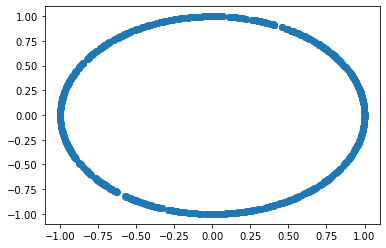

In [344]:
plt.scatter(data[:,0], data[:,1])

In [345]:
data_t = t.from_numpy(data)

In [346]:
data_t

tensor([[ 0.9496, -0.3136],
        [-0.4875, -0.8731],
        [ 0.4048,  0.9144],
        ...,
        [-0.5628,  0.8266],
        [-0.9937, -0.1122],
        [ 0.6271, -0.7789]])

In [347]:
discriminator = Sequential(Linear(2,512), LeakyReLU(0.2, inplace=True),
                           Linear(512,32), LeakyReLU(0.2, inplace=True),
                                Linear(32,1),  Sigmoid())

In [348]:
discriminator = discriminator.to(device) 

In [349]:

generator = Sequential(Linear(2,512), LeakyReLU(),
                               Linear(512,256), LeakyReLU(),
                               Linear(256,128), LeakyReLU(),
                                Linear(128,64), LeakyReLU(),
                                Linear(64,32), LeakyReLU(),
                               Linear(32,2))

In [350]:
generator= generator.to(device)

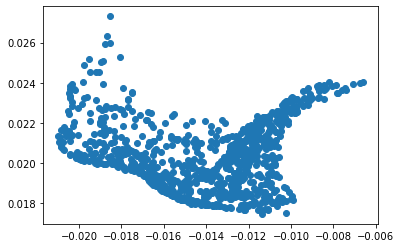

In [351]:
out_t = generator(t.empty(1000,2, device=device).uniform_(-1,1));
plt.scatter(out_t.data.cpu().numpy()[:,0],out_t.data.cpu().numpy()[:,1])

In [352]:
d_optimizer = t.optim.Adam(discriminator.parameters(), lr=0.0002)

In [353]:
g_optimizer = t.optim.Adam(generator.parameters(), lr=0.0002)

### Problem 1

Implement the GAN train loop that will train GAN to generate from the sample distribution.  

In [354]:
bce =t.nn.BCELoss()

500 1.394201397895813 0.7919485569000244


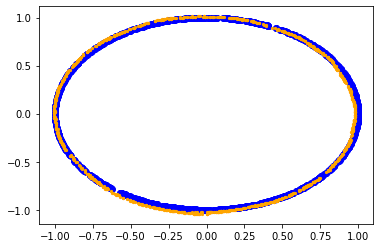

In [356]:

z_fixed = t.empty(1000,2, device=device).uniform_(-1,1)

mini_batch_size = 100
k_discriminator = 4
k_generator = 1
for epoch in range(1,501):
    for batch in range(len(data)//mini_batch_size):
        for k_d in range(k_discriminator):
            d_optimizer.zero_grad()
            kr = np.random.randint(0,len(data)//mini_batch_size )
    
            d = data_t[kr*mini_batch_size:(kr+1)*mini_batch_size]
            real_labels = t.ones(mini_batch_size, 1, device=device)
            d_real_loss = bce(discriminator(d), 0.9*real_labels)
    
            z = t.empty(mini_batch_size,2, device=device).uniform_(-1,1)
            g_out = generator(z)
            fake_labels = t.zeros(mini_batch_size, 1, device=device)
            d_fake_loss = bce(discriminator(g_out), fake_labels)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
    
        g_optimizer.zero_grad()
        z = t.empty(mini_batch_size,2, device=device).uniform_(-1,1)
        g_out = generator(z)
        g_loss = bce(discriminator(g_out), real_labels)
        g_loss.backward()
        g_optimizer.step()
        
    if epoch%25 == 0:
        with t.no_grad():
                z = t.empty(len(data_t),2, device=device).uniform_(-1,1)
                real_labels = t.ones(len(data_t),1, device=device)
                fake_labels = t.zeros(len(data_t),1, device=device)
                g_out =  generator(z)
                dg_out = discriminator(g_out)
                d_loss =  bce(discriminator(data_t), real_labels)
                d_loss +=  bce(dg_out, fake_labels)
                
                g_loss = bce(dg_out, real_labels)
                clear_output()
                print(epoch, d_loss.item(), g_loss.item())    
                
                out_t = generator(z_fixed);
                plt.scatter(data[:,0], data[:,1], c='b')
                plt.scatter(out_t.data.cpu().numpy()[:,0],out_t.data.cpu().numpy()[:,1],
                            c='orange',s=5)
                
                plt.show()


### Problem 2

Use another sampling distribution. One that is not concentrated on a line e.g. an ellipse. 

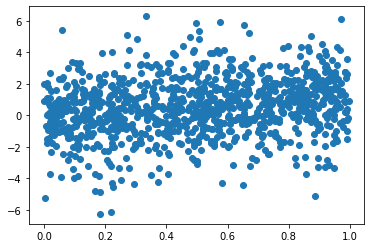

In [368]:
from scipy.special import factorial

x = np.random.uniform(0,1,(1000,1)).astype('float32')
y = np.random.logistic(x).astype('float32')
#x = np.array([np.arange(0, 1, 0.001)]).T.astype('float32')
#y = np.exp(-5)*np.power(5, x)/factorial(x).astype('float32')
plt.scatter(x, y)
data = np.concatenate((x, y), axis=1)
data_t = t.from_numpy(data)


In [369]:
data

array([[ 0.66616714,  2.2505848 ],
       [ 0.11815231,  0.8437909 ],
       [ 0.94211996,  2.5004327 ],
       ...,
       [ 0.6789919 , -2.7199728 ],
       [ 0.75568867, -0.3278396 ],
       [ 0.4803327 ,  2.3588948 ]], dtype=float32)

In [370]:
discriminator = Sequential(Linear(2,512), LeakyReLU(0.2, inplace=True),
                           Linear(512,32), LeakyReLU(0.2, inplace=True),
                                Linear(32,1),  Sigmoid())

In [371]:
discriminator = discriminator.to(device) 

In [372]:
generator = Sequential(Linear(2,512), LeakyReLU(),
                               Linear(512,256), LeakyReLU(),
                               Linear(256,128), LeakyReLU(),
                                Linear(128,64), LeakyReLU(),
                                Linear(64,32), LeakyReLU(),
                               Linear(32,2))

In [373]:
generator= generator.to(device)

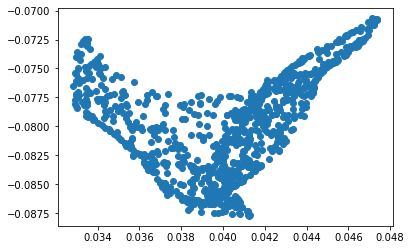

In [374]:
out_t = generator(t.empty(1000,2, device=device).uniform_(-1,1));
plt.scatter(out_t.data.cpu().numpy()[:,0],out_t.data.cpu().numpy()[:,1])

In [375]:
d_optimizer = t.optim.Adam(discriminator.parameters(), lr=0.0002)

In [376]:
g_optimizer = t.optim.Adam(generator.parameters(), lr=0.0002)

In [377]:
bce =t.nn.BCELoss()

500 1.3894306421279907 0.8150337934494019


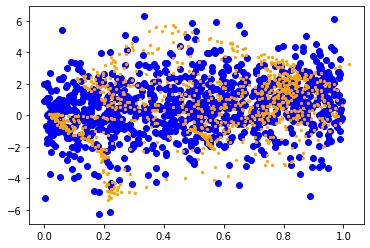

In [380]:

z_fixed = t.empty(1000,2, device=device).uniform_(-1,1)

mini_batch_size = 100
k_discriminator = 4
k_generator = 1
for epoch in range(1,501):
    for batch in range(len(data)//mini_batch_size):
        for k_d in range(k_discriminator):
            d_optimizer.zero_grad()
            kr = np.random.randint(0,len(data)//mini_batch_size )
    
            d = data_t[kr*mini_batch_size:(kr+1)*mini_batch_size]
            real_labels = t.ones(mini_batch_size, 1, device=device)
            d_real_loss = bce(discriminator(d), 0.9*real_labels)
    
            z = t.empty(mini_batch_size,2, device=device).uniform_(-1,1)
            g_out = generator(z)
            fake_labels = t.zeros(mini_batch_size, 1, device=device)
            d_fake_loss = bce(discriminator(g_out), fake_labels)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
    
        g_optimizer.zero_grad()
        z = t.empty(mini_batch_size,2, device=device).uniform_(-1,1)
        g_out = generator(z)
        g_loss = bce(discriminator(g_out), real_labels)
        g_loss.backward()
        g_optimizer.step()
        
    if epoch%25 == 0:
        with t.no_grad():
                z = t.empty(len(data_t),2, device=device).uniform_(-1,1)
                real_labels = t.ones(len(data_t),1, device=device)
                fake_labels = t.zeros(len(data_t),1, device=device)
                g_out =  generator(z)
                dg_out = discriminator(g_out)
                d_loss =  bce(discriminator(data_t), real_labels)
                d_loss +=  bce(dg_out, fake_labels)
                
                g_loss = bce(dg_out, real_labels)
                clear_output()
                print(epoch, d_loss.item(), g_loss.item())    
                
                out_t = generator(z_fixed);
                plt.scatter(data[:,0], data[:,1], c='b')
                plt.scatter(out_t.data.cpu().numpy()[:,0],out_t.data.cpu().numpy()[:,1],
                            c='orange',s=5)
                
                plt.show()
